In [3]:
using Revise
using OpenQuantumSystems
using LinearAlgebra
using SparseArrays
using Interpolations
using HDF5
using Measures

import Base.log10

In [2]:
using BenchmarkTools
using Plots
using ProgressBars
using OpenQuantumSystems
# using OpenQuantumSystemsPrivate
using LinearAlgebra
using Random
using QuadGK
using ProgressMeter
using Expokit
# using DifferentialEquations

Random.seed!(0)

import OrdinaryDiffEq, DiffEqCallbacks, DelayDiffEq
import SparseArrays: sparse
import QuantumOpticsBase

In [7]:
sim_labels = [
    "Evolution_sI_exact",
    "QME_sI_ansatz_test",
    "QME_sI_ansatz_const_int",
    "QME_sI_ansatz_const_sch",
    "QME_sI_ansatz_upart1_sch",
    "QME_sI_ansatz_upart1_int",
    "QME_sI_ansatz_upart2_sch",
    "QME_sI_ansatz_upart2_int",
    "QME_sI_iterative_1"
]

9-element Vector{String}:
 "Evolution_sI_exact"
 "QME_sI_ansatz_test"
 "QME_sI_ansatz_const_int"
 "QME_sI_ansatz_const_sch"
 "QME_sI_ansatz_upart1_sch"
 "QME_sI_ansatz_upart1_int"
 "QME_sI_ansatz_upart2_sch"
 "QME_sI_ansatz_upart2_int"
 "QME_sI_iterative_1"

In [6]:
function read_data_pt(filename)
    simulation_info, rho_int_l = h5open(filename, "r") do file
        simulation_info = Dict{String,Any}("n" => read(file, "n"))
        for key in ["hr1", "hr2", "tspan", "tspan_fs"]
            simulation_info[key] = read(file, key)
        end
        rho_int_l = []
        for li=1:length(sim_labels)
            label = sim_labels[li]
            push!(rho_int_l, read(file, label))
        end
        return simulation_info, rho_int_l
    end
    return simulation_info, rho_int_l
end

read_data_pt (generic function with 1 method)

In [8]:
tspan = get_tspan(0., 0.04, 500)
tspan_fs = tspan_cm_to_fs(tspan)
W0, rho0, W0_bath = ultrafast_laser_excitation(10., [0., 0.7, 0.3], agg_ge)
elLen = aggCore.molCount+1
tspan_fs[end]

212.35349835504582

In [10]:
simulation_info, rho_int_l = read_data_pt("data/hr_scan_0.05_0.05.h5")
println("")

In [12]:
simulation_info

Dict{String, Any} with 5 entries:
  "tspan_fs" => [0.0, 0.424707, 0.849414, 1.27412, 1.69883, 2.12353, 2.54824, 2…
  "tspan"    => [0.0, 8.0e-5, 0.00016, 0.00024, 0.00032, 0.0004, 0.00048, 0.000…
  "hr1"      => 0.05
  "hr2"      => 0.05
  "n"        => 0

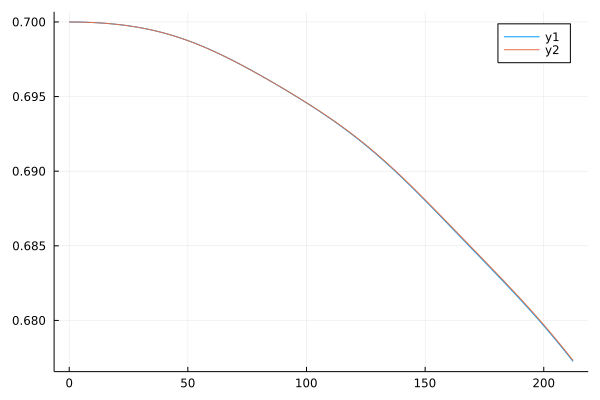

In [18]:
plot(tspan_fs, real(rho_int_l[1][:, 2, 2]))
plot!(tspan_fs, real(rho_int_l[9][:, 2, 2]))

In [11]:
function get_agg(hr1, hr2)
    mols = [
        Molecule([Mode(omega=200., hr_factor=hr1)], 3, [0., 12700.]),
        Molecule([Mode(omega=200., hr_factor=hr2)], 3, [0., 12500.])
    ]

    aggCore = AggregateCore(mols)
    for mol_i in 2:aggCore.molCount
        aggCore.coupling[mol_i, mol_i+1] = 50
        aggCore.coupling[mol_i+1, mol_i] = 50
    end
    agg = setupAggregate(aggCore)
end

get_agg (generic function with 1 method)